In [67]:
"""
Adversarial Attacks in Pytorch
 
Written by Harry Kim
Licensed under the MIT License

WARNING :: All images should be scaled to [0, 1] with transform[to.Tensor()] before used in attacks.
WARNING :: All models should return ONLY ONE vector of `(N, C)` where `C = number of classes`.
"""

import torch
import torch.nn as nn
import torch.optim as optim

class Attacks(object):
    """
    An abstract class representing attacks.

    Arguments:
        name (string): name of the attack.
        model (nn.Module): a model to attack.

    .. note:: device("cpu" or "cuda") will be automatically determined by a given model.
    
    """
    def __init__(self, name, model):
        self.attack = name
        self.model = model.eval()
        self.model_name = str(model).split("(")[0]
        self.device = torch.device("cuda" if next(model.parameters()).is_cuda else "cpu")
                
    # Whole structure of the model will be NOT displayed for pretty print.        
    def __str__(self):
        info = self.__dict__.copy()
        del info['model']
        del info['attack']
        return self.attack + "(" + ', '.join('{}={}'.format(key, val) for key, val in info.items()) + ")"
    
    # Save image data as torch tensor from data_loader
    # If you want to reduce the space of dataset, set 'to_unit8' as True
    # If you don't want to know about accuaracy of the model, set accuracy as False
    def save(self, file_name, data_loader, to_uint8 = True, accuracy = True):
        image_list = []
        label_list = []
        
        correct = 0
        total = 0
        
        total_batch = len(data_loader)
        
        for step, (images, labels) in enumerate(data_loader) :
            
            adv_images = self.__call__(images, labels)
            
            if accuracy :
                outputs = self.model(adv_images)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels.to(self.device)).sum()

            if to_uint8 :
                image_list.append((adv_images*255).type(torch.uint8).cpu())
            else :
                image_list.append(adv_images.cpu())
                
            label_list.append(labels)
        
            print('- Save Progress : %2.2f %%        ' %((step+1)/total_batch*100), end='\r')
        
        if accuracy :
            acc = 100 * float(correct) / total
            print('\n- Accuracy of model : %f %%' % (acc), end='')
        
        x = torch.cat(image_list, 0)
        y = torch.cat(label_list, 0)
        
        torch.save((x, y), file_name)
        
        print('\n- Save Complete!')
        
    # Load image data as torch dataset
    # When scale=True it automatically tansforms images to [0, 1]
    def load(self, file_name, scale = True) :
        adv_images, adv_labels = torch.load(file_name)
        
        if scale :
            adv_data = torch.utils.data.TensorDataset(adv_images.float() / adv_images.max(), adv_labels)
        else :
            adv_data = torch.utils.data.TensorDataset(adv_images.float(), adv_labels)
            
        return adv_data
    
    ########################################## DEPRECIATED ##########################################
    '''
    # Evaluate accuaracy of a model
    # With default 'model = None', it will return accuracy of white box attack
    # If not, it will return accuracy of black box attack with self.model as holdout model
    
    def eval(self, data_loader, model = None) :
        
        if model is None :
            model = self.model
        else :
            model = model.eval()

        correct = 0
        total = 0

        total_batch = len(data_loader)
        
        for step, (images, labels) in enumerate(data_loader) :

            adv_images = self.__call__(images, labels)
            outputs = model(adv_images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels.to(self.device)).sum()
            
            print('- Evaluation Progress : %2.2f %%        ' %((step+1)/total_batch*100), end='\r')

        accuracy = 100 * float(correct) / total
        print('\n- Accuracy of model : %f %%' % (accuracy))

        return accuracy
    '''
    
class FGSM(Attacks):
    """
    FGSM attack in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]

    Arguments:
        model (nn.Module): a model to attack.
        eps (float): epsilon in the paper. (DEFALUT : 0.007)
    
    """
    def __init__(self, model, eps=0.007):
        super(FGSM, self).__init__("FGSM", model)
        self.eps = eps
    
    def __call__(self, images, labels):
        images = images.to(self.device)
        labels = labels.to(self.device)
        loss = nn.CrossEntropyLoss()
        
        images.requires_grad = True
        outputs = self.model(images)

        self.model.zero_grad()
        cost = loss(outputs, labels).to(self.device)
        cost.backward()

        adv_images = images + self.eps*images.grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach_()

        return adv_images
        
        
class IFGSM(Attacks):
    """
    I-FGSM attack in the paper 'Adversarial Examples in the Physical World'
    [https://arxiv.org/abs/1607.02533]

    Arguments:
        model (nn.Module): a model to attack.
        eps (float): epsilon in the paper. (DEFALUT : 4/255)
        alpha (float): alpha in the paper. (DEFALUT : 1/255)
        iters (int): max iterations. (DEFALUT : 0)
    
    .. note:: With 0 iters, iters will be automatically decided with the formula in the paper.
    """
    def __init__(self, model, eps=4/255, alpha=1/255, iters=0):
        super(IFGSM, self).__init__("IFGSM", model)
        self.eps = eps
        self.alpha = alpha
        if iters == 0 :
            self.iters = int(min(eps*255 + 4, 1.25*eps*255))
        else :
            self.iters = iters
        
    def __call__(self, images, labels):
        images = images.to(self.device)
        labels = labels.to(self.device)
        loss = nn.CrossEntropyLoss()
        
        for i in range(self.iters) :    
            images.requires_grad = True
            outputs = self.model(images)

            self.model.zero_grad()
            cost = loss(outputs, labels).to(self.device)
            cost.backward()

            adv_images = images + self.alpha*images.grad.sign()
            
            a = torch.clamp(images - self.eps, min=0)
            b = (adv_images>=a).float()*adv_images + (a>adv_images).float()*a
            c = (b > images+self.eps).float()*(images+self.eps) + (images+self.eps >= b).float()*b
            images = torch.clamp(c, max=1).detach_()

        adv_images = images

        return adv_images
        
        
class IterLL(Attacks):
    """
    iterative least-likely class attack in the paper 'Adversarial Examples in the Physical World'
    [https://arxiv.org/abs/1607.02533]

    Arguments:
        model (nn.Module): a model to attack.
        eps (float): epsilon in the paper. (DEFALUT : 4/255)
        alpha (float): alpha in the paper. (DEFALUT : 1/255)
        iters (int): max iterations. (DEFALUT : 0)
    
    .. note:: With 0 iters, iters will be automatically decided with the formula in the paper.
    """
    def __init__(self, model, eps=4/255, alpha=1/255, iters=0):
        super(IterLL, self).__init__("IterLL", model)
        self.eps = eps
        self.alpha = alpha
        if iters == 0 :
            self.iters = int(min(eps*255 + 4, 1.25*eps*255))
        else :
            self.iters = iters
        
    def __call__(self, images, labels):
        images = images.to(self.device)
        
        outputs = self.model(images)
        _, labels = torch.min(outputs.data, 1)
        labels = labels.detach_()
        
        loss = nn.CrossEntropyLoss()
        
        for i in range(self.iters) :    
            images.requires_grad = True
            outputs = self.model(images)

            self.model.zero_grad()
            cost = loss(outputs, labels).to(self.device)
            cost.backward()

            adv_images = images - self.alpha*images.grad.sign()
            
            a = torch.clamp(images - self.eps, min=0)
            b = (adv_images>=a).float()*adv_images + (a>adv_images).float()*a
            c = (b > images+self.eps).float()*(images+self.eps) + (images+self.eps >= b).float()*b
            images = torch.clamp(c, max=1).detach_()

        adv_images = images

        return adv_images
        
class RFGSM(Attacks):
    """
    R+FGSM attack in the paper 'Ensemble Adversarial Training : Attacks and Defences'
    [https://arxiv.org/abs/1705.07204]

    Arguments:
        model (nn.Module): a model to attack.
        eps (float): epsilon in the paper. (DEFALUT : 16/255)
        alpha (float): alpha in the paper. (DEFALUT : 8/255)
        iters (int): max iterations. (DEFALUT : 1)
    
    """
    def __init__(self, model, eps=16/255, alpha=8/255, iters=1):
        super(RFGSM, self).__init__("RFGSM", model)
        self.eps = eps
        self.alpha = alpha
        self.iters = iters
    
    def __call__(self, images, labels):
        images = images.to(self.device)
        labels = labels.to(self.device)
        loss = nn.CrossEntropyLoss()

        images = images + self.alpha*torch.randn_like(images).sign()

        for i in range(self.iters) :
            images.requires_grad = True
            outputs = self.model(images)

            self.model.zero_grad()
            cost = loss(outputs, labels).to(self.device)
            cost.backward()

            adv_images = images + (self.eps-self.alpha)*images.grad.sign()
            images = torch.clamp(adv_images, min=0, max=1).detach_()

        adv_images = images
        
        return adv_images
    
class CW(Attacks):
    """
    CW(L2) attack in the paper 'Towards Evaluating the Robustness of Neural Networks'
    [https://arxiv.org/abs/1608.04644]

    Arguments:
        model (nn.Module): a model to attack.
        targeted (bool):  (DEFALUT : False)
            True - change image closer to a given label
            False  - change image away from a right label
        c (float): c in the paper. (DEFALUT : 1e-4)
        kappa (float): kappa (also written as 'confidence') in the paper. (DEFALUT : 0)
        iters (int): max iterations. (DEFALUT : 1000)
        lr (float): learning rate of the optimizer. (DEFALUT : 0.01)
        
    .. note:: There are serveral NOT IMPLEMENTED part of the paper/other codes.
    (1) Binary search method for c : It costs too many times.
    (2) Optimization on tanh space : Not in the paper, but in the other codes.
    (3) Choosing method best l2 adversaries : It will be implemented soon.
    
    .. warning:: With default c, you can't easily get adversarial images. Set higher c like 1.
    """
    def __init__(self, model, targeted=False, c=1e-4, kappa=0, iters=1000, lr=0.01):
        super(CW, self).__init__("CW", model)
        self.targeted = targeted
        self.c = c
        self.kappa = kappa
        self.iters = iters
        self.lr = lr
                
    def __call__(self, images, labels):
        images = images.to(self.device)
        labels = labels.to(self.device)
        
        # f-function in the paper
        def f(x) :

            outputs = self.model(x)
            one_hot_labels = torch.eye(len(outputs[0]))[labels].to(self.device)

            i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
            j = torch.masked_select(outputs, one_hot_labels.byte())

            # If targeted, optimize for making the other class most likely 
            if self.targeted :
                return torch.clamp(i-j, min=-self.kappa)

            # If untargeted, optimize for making the other class most likely 
            else :
                return torch.clamp(j-i, min=-self.kappa)
        
        w = torch.zeros_like(images).to(self.device)
        w.detach_()
        w.requires_grad=True
        
        optimizer = optim.Adam([w], lr=self.lr)
        prev = 1e10
                
        for step in range(self.iters) :    
            
            a = 1/2*(nn.Tanh()(w) + 1)

            loss1 = nn.MSELoss(reduction='sum')(a, images)
            loss2 = torch.sum(self.c*f(a))
            
            cost = loss1 + loss2

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            # Early Stop when loss does not converge.
            if step % (self.iters//10) == 0 :
                if cost > prev :
                    print('CW Attack is stopped due to CONVERGENCE....')
                    return a
                prev = cost
            
            print('- CW Attack Progress : %2.2f %%        ' %((step+1)/self.iters*100), end='\r')
            
        adv_images = (1/2*(nn.Tanh()(w) + 1)).detach_()

        return adv_images
        
class PGD(Attacks):
    """
    CW attack in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]

    Arguments:
        model (nn.Module): a model to attack.
        eps (float): epsilon in the paper. (DEFALUT : 0.3)
        alpha (float): alpha in the paper. (DEFALUT : 2/255)
        iters (int): max iterations. (DEFALUT : 40)
        
    """
    def __init__(self, model, eps=0.3, alpha=2/255, iters=40):
        super(PGD, self).__init__("PGD", model)
        self.eps = eps
        self.alpha = alpha
        self.iters = iters
    
    def __call__(self, images, labels):
        images = images.to(self.device)
        labels = labels.to(self.device)
        loss = nn.CrossEntropyLoss()

        ori_images = images.data
        
        for i in range(self.iters) :    
            images.requires_grad = True
            outputs = self.model(images)

            self.model.zero_grad()
            cost = loss(outputs, labels).to(self.device)
            cost.backward()

            adv_images = images + self.alpha*images.grad.sign()
            eta = torch.clamp(adv_images - ori_images, min=-self.eps, max=self.eps)
            images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

        adv_images = images
        
        return adv_images
    

# Demo - Adversarial Attack with Imagenet

In [68]:
import numpy as np
import json
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [71]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [72]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [73]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [74]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

## 1. Load Data

In [75]:
normal_data = image_folder_custom_label(root = './data/imagenet', transform = transform, custom_label = idx2label)
normal_loader = torch.utils.data.DataLoader(normal_data, batch_size=1, shuffle=False)

True Image & True Label


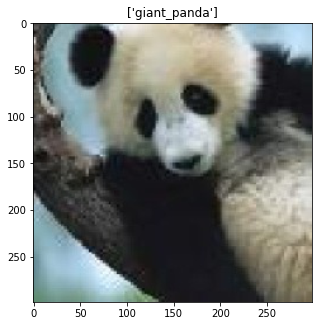

In [76]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 2. Attack Inception v3

In [77]:
model = models.inception_v3(pretrained=True).to(device)

fgsm_attack = FGSM(model)
ifgsm_attack = IFGSM(model)
iterll_attack = IterLL(model)
rfgsm_attack = RFGSM(model)
cw_attack = CW(model, c=1)
pgd_attack = PGD(model)

attacks = [fgsm_attack, ifgsm_attack, iterll_attack, rfgsm_attack, cw_attack, pgd_attack]

In [42]:
print("Attack Image & Predicted Label")

model.eval()

for attack in attacks :
    
    print("-"*70)
    print(attack)
    
    attack.save(normal_loader)

Attack Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Inception3, device=cuda, eps=0.007)
- Evaluation Progress : 100.00 %        
 - Accuracy of model : 0.000000 %
----------------------------------------------------------------------
IFGSM(model_name=Inception3, device=cuda, eps=0.01568627450980392, alpha=0.00392156862745098, iters=5)
- Evaluation Progress : 100.00 %        
 - Accuracy of model : 0.000000 %
----------------------------------------------------------------------
IterLL(model_name=Inception3, device=cuda, eps=0.01568627450980392, alpha=0.00392156862745098, iters=5)
- Evaluation Progress : 100.00 %        
 - Accuracy of model : 0.000000 %
----------------------------------------------------------------------
RFGSM(model_name=Inception3, device=cuda, eps=0.06274509803921569, alpha=0.03137254901960784, iters=1)
- Evaluation Progress : 100.00 %        
 - Accuracy of model : 0.000000 %
-----------------------

## 3. Save Adversarial Images

In [78]:
pgd_attack.save(file_name="pgd_inceptionv3.pt", data_loader=normal_loader, to_uint8=True)

- Save Progress : 100.00 %        
- Accuracy of model : 0.000000 %
- Save Complete!


## 4. Load Adversarial Images

In [16]:
adv_data = pgd_attack.load(file_name="pgd_inceptionv3.pt")
adv_loader = torch.utils.data.DataLoader(adv_data, batch_size=1, shuffle=False)

Adversarial Image & True Label


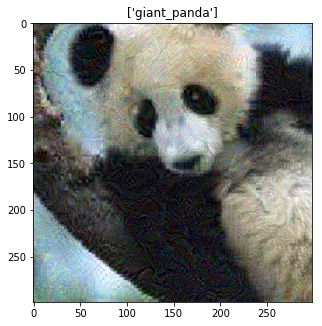

In [14]:
adv_iter = iter(adv_loader)
images, labels = adv_iter.next()

print("Adversarial Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])